<a href="https://colab.research.google.com/github/itimes-digital/olist_analise/blob/main/olist_analise_de_negocio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ds_clientes = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_customers_dataset.csv?raw=true');
ds_pedido_itens = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_order_items_dataset.csv?raw=true');
ds_pedido_pagamentos = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_order_payments_dataset.csv?raw=true');
ds_reviews = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_order_reviews_dataset.csv?raw=true');
ds_pedidos = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_orders_dataset.csv?raw=true');
ds_produtos = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_products_dataset.csv?raw=true');
ds_vendedores = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_sellers_dataset.csv?raw=true');
ds_categorias = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/product_category_name_translation.csv?raw=true');

In [5]:
ds_clientes.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [33]:
ds_clientes.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
ds_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [8]:
ds_clientes.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

## Percentual de Clientes e Recorrência de Compras

In [31]:
total_clientes = ds_clientes['customer_id'].nunique()
total_unico = ds_clientes['customer_unique_id'].nunique()

percentual = round((total_unico / total_clientes) * 100, 2)

diferenca = total_clientes - total_unico

print('Dos {0} compradores registrados, temos {1}% de compradores com apenas um registro de compra.'.format(total_clientes, percentual))
print('\nEnquanto isso, temos apenas {0} clientes que voltaram a comprar na loja.'.format(diferenca))
print('\nPortanto, {0}% de recorrência.'.format(round((100 - percentual), 2)))
print('\nEm um primeiro momento, podemos concluir que o LTV - LifeTime Value - desta amostra está alto.')

Dos 99441 compradores registrados, temos 96.64% de compradores com apenas um registro de compra.

Enquanto isso, temos apenas 3345 clientes que voltaram a comprar na loja.

Portanto, 3.36% de recorrência.

Em um primeiro momento, podemos concluir que o LTV - LifeTime Value - desta amostra está alto.


In [63]:
ds_novo_clientes_cluster = ds_clientes[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']]
ds_novo_clientes_cluster.head()

,customer_id,customer_unique_id,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,SP


## Distribuição de Clientes pelo Brasil

A maior concentração de clientes encontra-se na região sudeste e sul, ultrapassando a marca de +70 mil clientes.

Porém, o consumo está mais atrelado as capitais, sendo a cidade de São Paulo com 15.540 compradores em um universo de 99.441 clientes.

In [64]:
ds_novo_clientes_cluster['customer_state'].describe()

count     99441
unique       27
top          SP
freq      41746
Name: customer_state, dtype: object

In [65]:
ds_novo_clientes_cluster['customer_state'].value_counts()

SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_state, dtype: int64

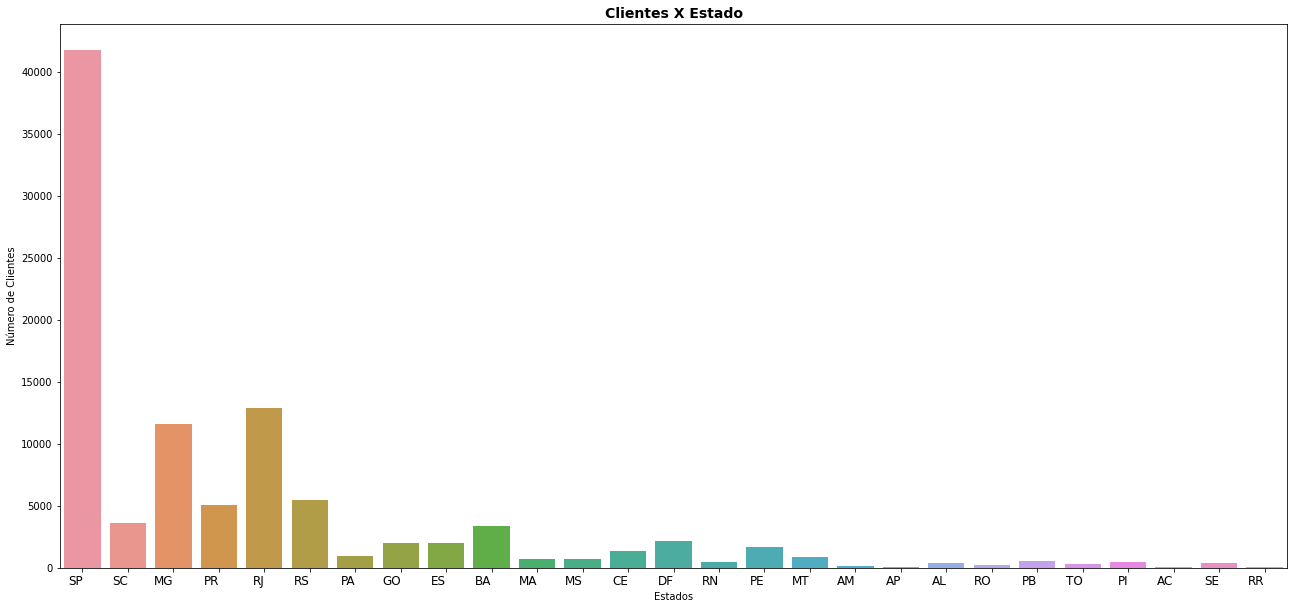

In [66]:
estados = ds_novo_clientes_cluster['customer_state'].unique()
plt.figure(figsize=(22,10))

ax = sns.countplot(x = 'customer_state',  
                   data = ds_novo_clientes_cluster, 
                   order = estados)

ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation = 0, 
                   ha = 'right', 
                   fontsize = 12)

plt.title('Clientes X Estado', fontsize = 14, fontweight = 'bold')
plt.xlabel('Estados') 
plt.ylabel('Número de Clientes')
plt.show()

In [67]:
ds_novo_clientes_cluster['customer_city'].describe()

count         99441
unique         4119
top       sao paulo
freq          15540
Name: customer_city, dtype: object

In [68]:
ds_novo_clientes_cluster['customer_city'].value_counts()

sao paulo            15540
rio de janeiro        6882
belo horizonte        2773
brasilia              2131
curitiba              1521
                     ...  
bequimao                 1
andarai                  1
vargem grande            1
curvelandia              1
eugenio de castro        1
Name: customer_city, Length: 4119, dtype: int64

In [71]:
ds_pedido_itens.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [75]:
ds_pedido_itens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [76]:
ds_pedido_itens.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [87]:
ds_pedido_itens.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [77]:
ds_pedido_itens.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


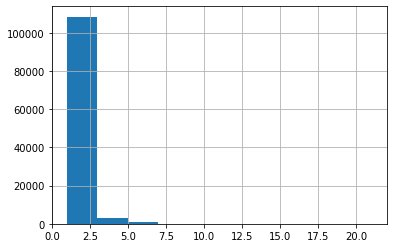

In [99]:
ds_pedido_itens['order_item_id'].hist()

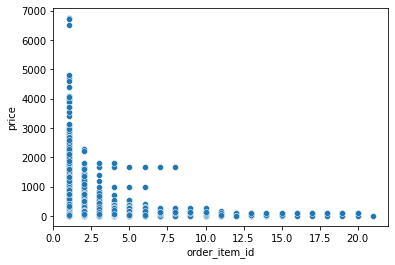

In [102]:
sns.scatterplot(data=ds_pedido_itens, x="order_item_id", y="price")

In [106]:
ds_pedido_itensunificados = ds_pedido_itens[['order_id', 'order_item_id', 'price', 'freight_value']]
ds_pedido_itensunificados.head()

,order_id,order_item_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,18.14


In [85]:
ds_pedido_frete_pago = ds_pedido_itens.query('freight_value != 0.0')
ds_pedido_frete_pago.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [94]:
ds_pedido_frete_pago.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112267 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112267 non-null  object 
 1   order_item_id        112267 non-null  int64  
 2   product_id           112267 non-null  object 
 3   seller_id            112267 non-null  object 
 4   shipping_limit_date  112267 non-null  object 
 5   price                112267 non-null  float64
 6   freight_value        112267 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.9+ MB


In [86]:
ds_pedido_frete_pago.describe()

,order_item_id,price,freight_value
count,112267.000000,112267.000000,112267.000000
mean,1.198010,120.728970,20.058517
std,0.705803,183.919245,15.790087
min,1.000000,0.850000,0.010000
25%,1.000000,39.900000,13.100000
50%,1.000000,74.900000,16.290000
75%,1.000000,134.990000,21.170000
max,21.000000,6735.000000,409.680000


In [83]:
ds_pedido_frete_gratis = ds_pedido_itens.query('freight_value == 0.0')
ds_pedido_frete_gratis.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
114,00404fa7a687c8c44ca69d42695aae73,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-15 04:31:26,99.9,0.0
258,00a870c6c06346e85335524935c600c0,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-05-14 00:14:29,69.9,0.0
483,011c899816ea29773525bd3322dbb6aa,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-07 05:30:45,99.9,0.0
508,012b3f6ab7776a8ab3443a4ad7bef2e6,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
509,012b3f6ab7776a8ab3443a4ad7bef2e6,2,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0


In [84]:
ds_pedido_frete_gratis.describe()

,order_item_id,price,freight_value
count,383.000000,383.000000,383.0
mean,1.146214,98.601488,0.0
std,0.462782,50.004247,0.0
min,1.000000,53.900000,0.0
25%,1.000000,69.900000,0.0
50%,1.000000,99.900000,0.0
75%,1.000000,106.900000,0.0
max,5.000000,712.900000,0.0


In [72]:
ds_pedidos.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [88]:
ds_pedidos.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [103]:
ds_pedidos['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [105]:
ds_pedidos['order_status'].query('order_status == "delivered"').count()

AttributeError: ignored

In [73]:
ds_pedido_pagamentos.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [74]:
ds_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
